<a href="https://colab.research.google.com/github/anandaero747/UMDAOSC650/blob/main/NN1_Inner_Problem.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Loading all libraries

In [42]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn import preprocessing
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, Input
from keras.models import Sequential
from keras.layers import Dense

# Giving access to my google drive to input data

In [43]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#Importing data

In [48]:
# This is the path in my gdrive where csv files are stored.
path_cl  = '/content/drive/MyDrive/Colab Notebooks/csv_Files/cl_input_perturbed.csv'
path_cd = '/content/drive/MyDrive/Colab Notebooks/csv_Files/cd_input_perturbed.csv'
path_cm = '/content/drive/MyDrive/Colab Notebooks/csv_Files/cm_input_perturbed.csv'

In [49]:
cl_input = pd.read_csv(path_cl)
cd_input = pd.read_csv(path_cd)
cm_input = pd.read_csv(path_cm)

# Inputs

In [5]:
X_coef = cl_input[['a1','a2','a3','a4','a5','a6','a7','a8','a9','a10','a11','a12','a13','a14','a15','a16','a17','a18','a19','a20']].copy()
X_rey = cl_input[['rey']].copy()

# Converting dataframe to numpy array

In [6]:
X_coef = X_coef.to_numpy()
X_rey = X_rey.to_numpy()

# Outputs

In [7]:
Y_cl = cl_input[['cl1','cl2','cl3','cl4','cl5','cl6','cl7','cl8','cl9','cl10','cl11','cl12','cl13','cl14','cl15','cl16','cl17','cl18','cl19','cl20','cl21','cl22','cl23','cl24','cl25']].copy()
Y_cd = cd_input[['cd1','cd2','cd3','cd4','cd5','cd6','cd7','cd8','cd9','cd10','cd11','cd12','cd13','cd14','cd15','cd16','cd17','cd18','cd19','cd20','cd21','cd22','cd23','cd24','cd25']].copy()
Y_cm = cm_input[['cm1','cm2','cm3','cm4','cm5','cm6','cm7','cm8','cm9','cm10','cm11','cm12','cm13','cm14','cm15','cm16','cm17','cm18','cm19','cm20','cm21','cm22','cm23','cm24','cm25']].copy()


# Converting dataframe to numpy array

In [8]:
Y_cl = Y_cl.to_numpy()
Y_cd = Y_cd.to_numpy()
Y_cm = Y_cm.to_numpy()

# Concatinating all inputs and outputs

In [9]:
X = np.concatenate((X_coef,X_rey), axis = 1)
Y = np.concatenate((Y_cl,Y_cd,Y_cm), axis = 1)

In [10]:
print(X.shape)
print(Y.shape)

(3502, 21)
(3502, 75)


# Train Test Split

In [11]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=0)

## Scaling Y & X

In [12]:
# Scaling inputs and outputs for the train data and using the same mean and std for test data scaling
scaler_X = preprocessing.StandardScaler().fit(X_train)
X_train_std = scaler_X.transform(X_train)

scaler_Y = preprocessing.StandardScaler().fit(Y_train)
Y_train_std = scaler_Y.transform(Y_train)


# Notice, the mean and std from train data is used to scale the test data as well.
X_test_std = scaler_X.transform(X_test)
Y_test_std = scaler_Y.transform(Y_test)


# Importing keras regularization library and Huber loss function

In [13]:
from tensorflow.keras.regularizers import l2
from keras.losses import Huber


# Hyper parameters tuning using KerasTuner

In [ ]:
pip install keras-tuner


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 1.2 MB/s eta 0:00:00


# Hyperparameters tuning using keras tuner.
# Tuning number of hidden layers and neurons per layer
# Other hyperparameters are chosen based on the understanding of the data

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from kerastuner import RandomSearch

# define the model-building function for Keras Tuner
def build_model(hp):
    model = keras.Sequential()
    # add input layer
    model.add(layers.Dense(units=hp.Int('input_units', min_value=10, max_value=100, step=10), activation='tanh', input_shape=(X_train_std.shape[1],)))
    # add variable number of hidden layers
    for i in range(hp.Int('num_layers', min_value=1, max_value=5)):
        model.add(layers.Dense(units=hp.Int('units_' + str(i), min_value=10, max_value=100, step=10), activation='tanh'))
    # add output layer
    model.add(layers.Dense(Y_train_std.shape[1]))
    # compile the model
    model.compile(optimizer='adam', loss=Huber(delta=1.35), metrics=['mean_absolute_error'])
    return model

# define the search space for Keras Tuner
tuner_search = RandomSearch(build_model, objective='val_loss', max_trials=10, directory='output', project_name='regression')

# perform Keras Tuner search
tuner_search.search(X_train_std, Y_train_std, epochs=500, validation_split=0.2)

# print the optimal hyperparameters
best_model = tuner_search.get_best_models(num_models=1)[0]
print(best_model.summary())


Trial 10 Complete [00h 02m 23s]
val_loss: 0.003843164537101984

Best val_loss So Far: 0.002836755244061351
Total elapsed time: 00h 22m 31s
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 90)                1980      
                                                                 
 dense_1 (Dense)             (None, 30)                2730      
                                                                 
 dense_2 (Dense)             (None, 20)                620       
                                                                 
 dense_3 (Dense)             (None, 30)                630       
                                                                 
 dense_4 (Dense)             (None, 100)               3100      
                                                                 
 dense_5 (Dense)             (None, 75)          

# Using the best hyperparameters value from the above cell

In [14]:
# Using Keras functional API --. The hidden layers and number of neurons per layer is same as the one given by KerasTuner
# l2 regularization in every layer to prevent overfitting
inputs_fwd = Input(shape= (X_train_std.shape[1],))
Fwd_layer_1 = Dense(90,activity_regularizer=l2(0.0001), activation = 'tanh')(inputs_fwd)
Fwd_layer_2 = Dense(30,activity_regularizer=l2(0.0001), activation = 'tanh')(Fwd_layer_1)
Fwd_layer_3 = Dense(20,activity_regularizer=l2(0.0001), activation = 'tanh')(Fwd_layer_2)
Fwd_layer_4 = Dense(30,activity_regularizer=l2(0.0001), activation = 'tanh')(Fwd_layer_3)
Fwd_layer_5 = Dense(100,activity_regularizer=l2(0.0001), activation = 'tanh')(Fwd_layer_4)
output_fwd = Dense(Y_train_std.shape[1])(Fwd_layer_5)

forwardmodel = keras.Model(inputs_fwd, output_fwd)
print(forwardmodel.summary())

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 21)]              0         
                                                                 
 dense (Dense)               (None, 90)                1980      
                                                                 
 dense_1 (Dense)             (None, 30)                2730      
                                                                 
 dense_2 (Dense)             (None, 20)                620       
                                                                 
 dense_3 (Dense)             (None, 30)                630       
                                                                 
 dense_4 (Dense)             (None, 100)               3100      
                                                                 
 dense_5 (Dense)             (None, 75)                7575  

In [15]:
forwardmodel.compile(loss =  Huber(delta=1.35) , optimizer = 'adam') # Huber loss function and adam optimizer
history_fwd = forwardmodel.fit(X_train_std, Y_train_std, batch_size=32, epochs=500, validation_split = 0.2, verbose = 0)

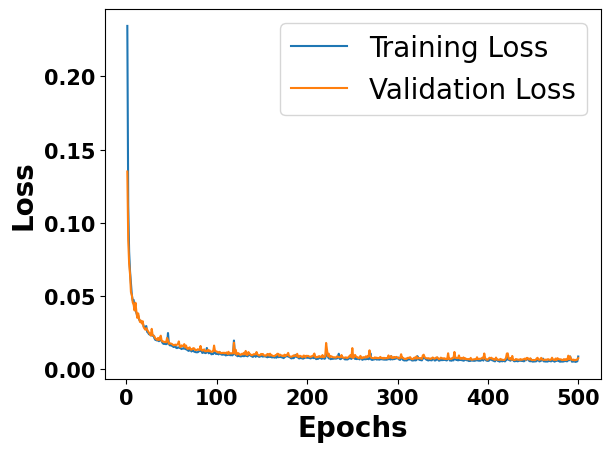

In [18]:
train_metrics = history_fwd.history['loss']
val_metrics = history_fwd.history['val_'+'loss']
epochs = range(1, len(train_metrics) + 1)
plt.plot(epochs, train_metrics)
plt.plot(epochs, val_metrics)
plt.xlabel("Epochs", fontsize=20,fontweight='bold')
plt.ylabel('Loss', fontsize=20,fontweight='bold')
plt.legend(["Training "+'Loss', 'Validation '+'Loss'], fontsize=20)
plt.xticks(fontsize=15,fontweight='bold')
plt.yticks(fontsize=15, fontweight = 'bold')
plt.show()

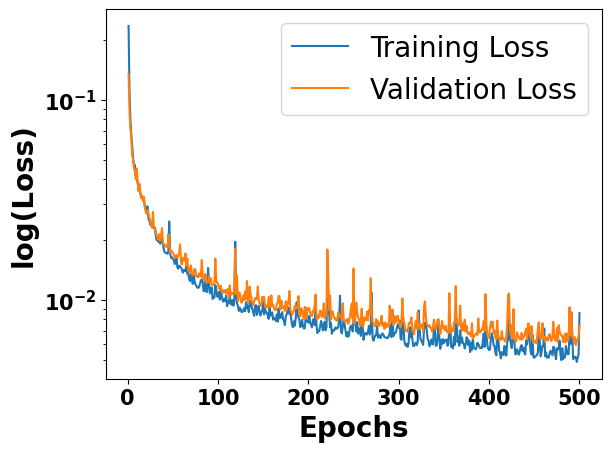

In [24]:
train_metrics = history_fwd.history['loss']
val_metrics = history_fwd.history['val_'+'loss']
epochs = range(1, len(train_metrics) + 1)
plt.semilogy(epochs, train_metrics)
plt.semilogy(epochs, val_metrics)
plt.xlabel("Epochs", fontsize=20,fontweight='bold')
plt.ylabel('log(Loss)', fontsize=20,fontweight='bold')
plt.legend(["Training "+'Loss', 'Validation '+'Loss'], fontsize=20)
plt.xticks(fontsize=15,fontweight='bold')
plt.yticks(fontsize=15, fontweight = 'bold')
plt.show()

In [ ]:
#forwardmodel.save('/content/drive/MyDrive/Colab Notebooks/Models/IPF_Poster/Thickness/forward')

# Predicting the outputs from the trained NN

In [25]:
Y_pred_std = forwardmodel.predict(X_test_std)

33/33 [==============================] - 0s 2ms/step


# Inverse scaling to get the outputs in original scale

In [26]:
Y_pred_orig = scaler_Y.inverse_transform(Y_pred_std)
Y_test_orig = scaler_Y.inverse_transform(Y_test_std)

# Comparison of True vs Predicted Values

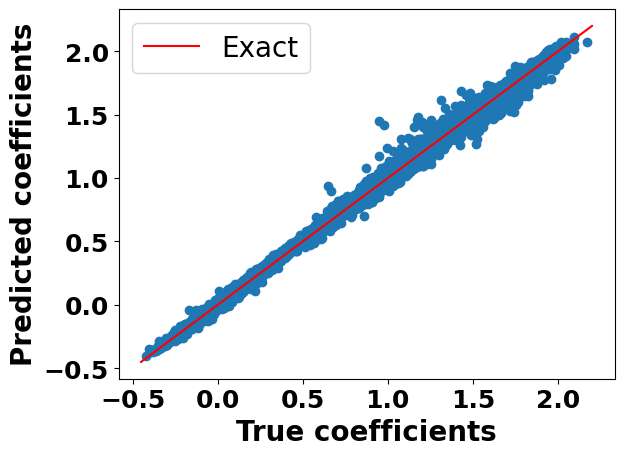

In [37]:
plt.plot([-0.45,2.2],[-0.45,2.2], c = 'red')
plt.scatter(Y_test_orig[:,:],Y_pred_orig[:,:])
plt.xlabel('True coefficients',fontsize=20,fontweight='bold')
plt.ylabel('Predicted coefficients',fontsize=20,fontweight='bold')
plt.xticks(size = 18,fontweight='bold')
plt.yticks(size = 18,fontweight='bold')
plt.legend(['Exact'],fontsize=20)
plt.show()

# Evaluating the performance of Neural Networks

In [38]:
from sklearn.metrics import mean_squared_error
from sklearn import metrics

In [41]:
rmse = 0.0
for i in range(0, 25): # Only for Cl load coefficient
  rmse = rmse + np.sqrt(mean_squared_error(Y_test_orig[:,i], Y_pred_orig[:,i]))

rmse_final = rmse / Y_test_orig.shape[1]
print("RMSE of CL on test data: ", rmse_final)

RMSE of CL on test data:  0.006537516000432246


# The RMSE error of the test data is 0.006.